In [1]:
import json
from typing import List

import numpy.typing as npt
from matplotlib import pyplot as plt

import spectrum_painting_data as sp_data
import spectrum_painting_plotting as sp_plot
import spectrum_painting_training as sp_training
from training.result import Result
from training.spectrum_painting import augment_spectrogram, downsample_spectrogram, paint_spectrogram


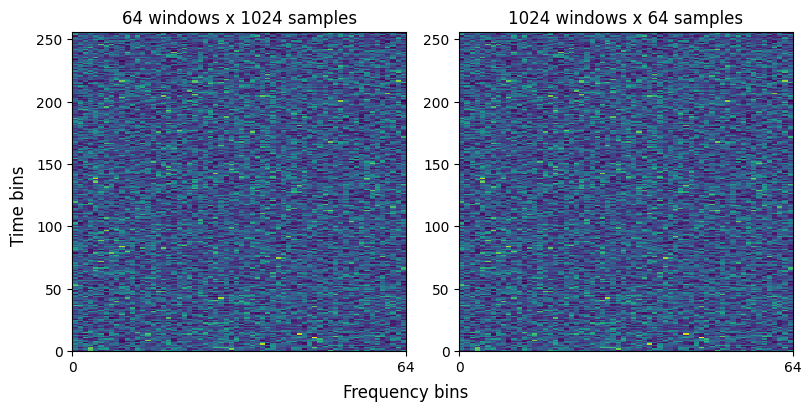

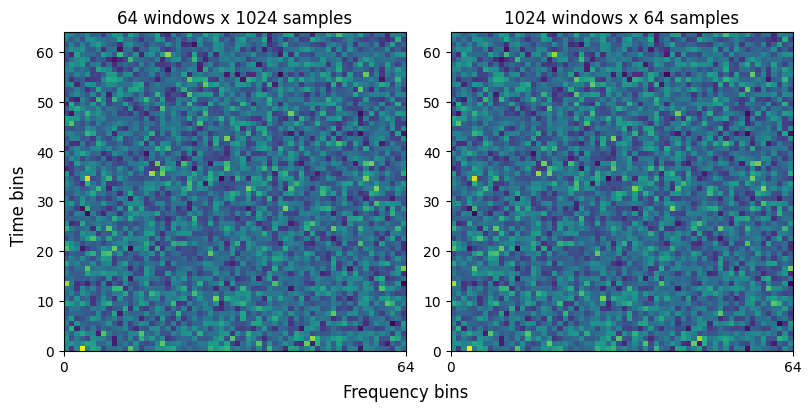

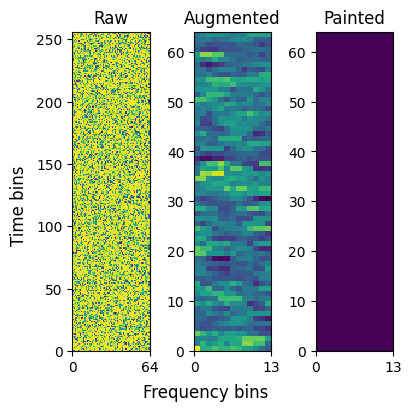

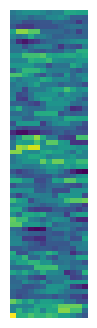

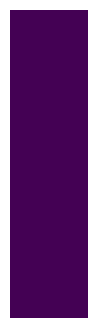

In [2]:
classes = ["ZBW"]
snr = -15

spectrum_painting_options = sp_training.SpectrumPaintingTrainingOptions(
    downsample_resolution=64,
    k=3,
    l=16,
    d=4
)

high_freq_resolution_spec = sp_data.load_spectrograms(data_dir="data/numpy",
                                                      classes=classes,
                                                      snr_list=[snr],
                                                      windows_per_spectrogram=256,
                                                      window_length=256,
                                                      nfft=64).get(snr)[0].values

high_time_resolution_spec = sp_data.load_spectrograms(data_dir="data/numpy",
                                                      classes=classes,
                                                      snr_list=[snr],
                                                      windows_per_spectrogram=256,
                                                      window_length=256,
                                                      nfft=64).get(snr)[0].values

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True)


def plot_spectrogram(spectrogram: npt.NDArray, index: int, name: str):
    plt.subplot(1, 2, index)
    plt.pcolormesh(spectrogram)
    plt.title(name)
    plt.xticks((0, spectrogram.shape[1]))
    plt.xticks()


plot_spectrogram(high_freq_resolution_spec, 1, "64 windows x 1024 samples")
plot_spectrogram(high_time_resolution_spec, 2, "1024 windows x 64 samples")

fig.supxlabel("Frequency bins")
fig.supylabel("Time bins")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True)

plot_spectrogram(downsample_spectrogram(high_freq_resolution_spec, 64), 1, "64 windows x 1024 samples")
plot_spectrogram(downsample_spectrogram(high_time_resolution_spec, 64), 2, "1024 windows x 64 samples")

fig.supxlabel("Frequency bins")
fig.supylabel("Time bins")
plt.show()

spec = sp_data.load_spectrograms(data_dir="data/numpy",
                                 classes=classes,
                                 snr_list=[snr],
                                 windows_per_spectrogram=256,
                                 window_length=256,
                                 nfft=64).get(snr)[0].values

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(4, 4), constrained_layout=True)


def plot_spectrogram(spectrogram: npt.NDArray, index: int, name: str):
    plt.subplot(1, 3, index)
    plt.pcolormesh(spectrogram)
    plt.title(name)
    plt.xticks((0, spectrogram.shape[1]))
    plt.xticks()


plot_spectrogram(spec.clip(max=0.04), index=1, name="Raw")

downsampled = downsample_spectrogram(spectrogram=spec, resolution=64)

augmented = augment_spectrogram(spectrogram=downsampled, k=3, l=16, d=4)
plot_spectrogram(augmented, index=2, name="Augmented")

painted = paint_spectrogram(downsampled, augmented)
plot_spectrogram(painted, index=3, name="Painted")

# fig.tight_layout()
fig.supxlabel("Frequency bins")
fig.supylabel("Time bins")
plt.show()

plt.figure(figsize=(1, 4))
plt.pcolormesh(augmented)
plt.axis("off")
plt.yticks(None)
plt.show()

plt.figure(figsize=(1, 4))
plt.pcolormesh(painted)
plt.axis("off")
plt.yticks(None)
plt.show()

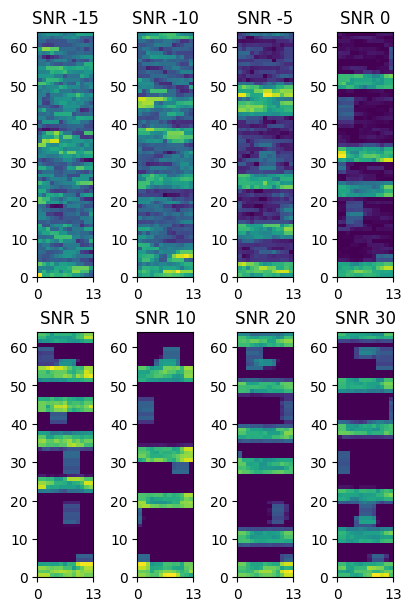

In [3]:
snr_list = [-15, -10, -5, 0, 5, 10, 20, 30]

spectrogram = sp_data.load_spectrograms(data_dir="data/numpy",
                                        classes=["ZBW"],
                                        snr_list=snr_list,
                                        windows_per_spectrogram=256,
                                        window_length=256,
                                        nfft=64)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(4, 6), constrained_layout=True)


def plot_spectrogram(spectrogram: npt.NDArray, index: int, name: str):
    plt.subplot(2, 4, index)
    plt.pcolormesh(spectrogram)
    plt.title(name)
    plt.xticks((0, spectrogram.shape[1]))
    plt.xticks()


for i, snr in enumerate(snr_list):
    spec = spectrogram[snr][0].values

    downsampled = downsample_spectrogram(spectrogram=spec, resolution=64)
    augmented = augment_spectrogram(spectrogram=downsampled, k=3, l=16, d=4)

    plot_spectrogram(augmented, i + 1, f"SNR {snr}")

# Read the results and create plots from notebook_spectrum_painting

/Users/sethd/Desktop/spectrum-painting/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


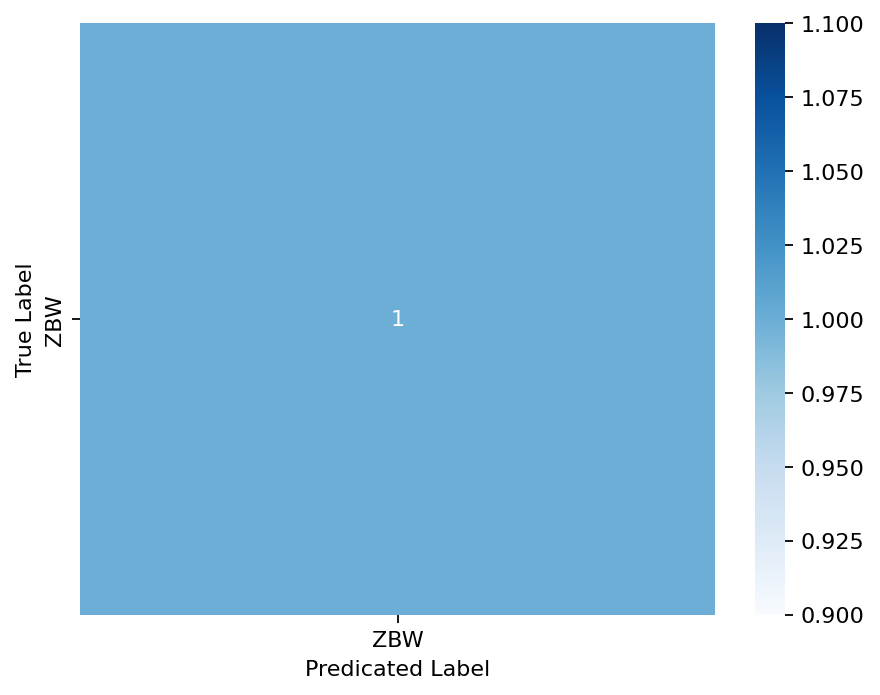

/Users/sethd/Desktop/spectrum-painting/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


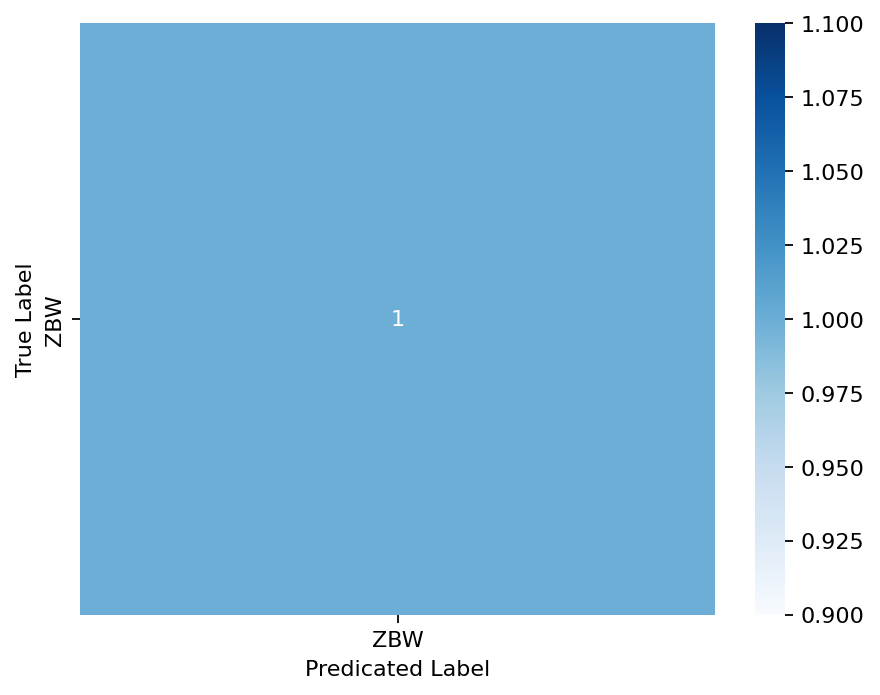

/Users/sethd/Desktop/spectrum-painting/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


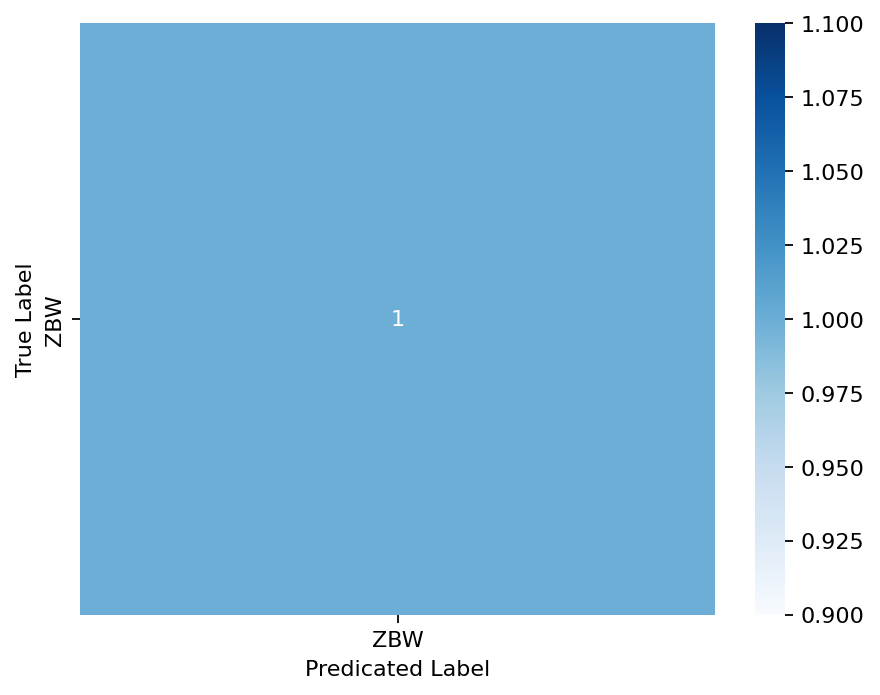

In [5]:
file_name = "results-20240616-183423.json"
results: List[Result]

with open(f"output/{file_name}", "r") as f:
    results = json.load(f)["results"]
    results = [Result.from_dict(r) for r in results]

confusion_matrix_result: Result = list(filter(lambda r: r.snr == 30, results))[0]

sp_plot.plot_confusion_matrix(confusion_matrix_result.full_model_predictions,
                              confusion_matrix_result.full_model_labels,
                              confusion_matrix_result.label_names)

sp_plot.plot_confusion_matrix(confusion_matrix_result.lite_model_predictions,
                              confusion_matrix_result.lite_model_labels,
                              confusion_matrix_result.label_names)

sp_plot.plot_confusion_matrix(confusion_matrix_result.lite_model_no_quant_predictions,
                              confusion_matrix_result.lite_model_no_quant_labels,
                              confusion_matrix_result.label_names)